In [ ]:
!pip install transformers nltk numpy datasets==2.16.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from PIL import Image
import numpy as np

dataset = load_dataset("flaviagiammarino/path-vqa")

# Extracting answers from all dataset splits
train_answers = [item['answer'] for item in dataset['train']]
val_answers = [item['answer'] for item in dataset['validation']]
test_answers = [item['answer'] for item in dataset['test']]

# Combining all answers into one set to eliminate the duplicate answers
all_answers = set(train_answers + val_answers + test_answers)
unique_answers = list(all_answers)
# assigning index value to each answer to classify among the number of unique answers
answer_to_id = {answer: idx for idx, answer in enumerate(unique_answers)}
num_classes = len(unique_answers)

# custom dataset class
class VQADataset(Dataset):
    def __init__(self, dataset, tokenizer, answer_to_id, transform=None):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.answer_to_id = answer_to_id
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        question = item['question']
        answer = item['answer']
        question_enc = self.tokenizer(question, return_tensors='pt', padding=True, truncation=True)
        answer_id = torch.tensor(self.answer_to_id[answer])
        return image, question_enc, answer_id

# Defining the transformations to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom collate for padding so, each question will be of same length
def collate_fn(batch):
    images, questions, answers = zip(*batch)

    images = torch.stack(images)

    questions_input_ids = torch.nn.utils.rnn.pad_sequence(
        [q['input_ids'].squeeze() for q in questions], batch_first=True, padding_value=tokenizer.pad_token_id
    )
    questions_attention_mask = torch.nn.utils.rnn.pad_sequence(
        [q['attention_mask'].squeeze() for q in questions], batch_first=True, padding_value=0
    )

    questions = {
        'input_ids': questions_input_ids,
        'attention_mask': questions_attention_mask
    }

    answers = torch.stack(answers)

    return images, questions, answers

# Creating DataLoaders
train_dataset = VQADataset(dataset['train'], tokenizer, answer_to_id, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

val_dataset = VQADataset(dataset['validation'], tokenizer, answer_to_id, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

test_dataset = VQADataset(dataset['test'], tokenizer, answer_to_id, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/19654 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6259 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6719 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# printing the total number of classes for classification
print(num_classes)

4879


In [ ]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [ ]:
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel
from vit_pytorch import ViT

# ResNet-101 Model with additional convolution layers
class EnhancedResNet(nn.Module):
    def __init__(self):
        super(EnhancedResNet, self).__init__()
        self.resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])  # Exclude the last two layers
        self.additional_cnn = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7)),  # Adapted the pooling size to prevent zero-sized output
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(512, 768)

    def forward(self, x):
        x = self.resnet(x)
        x = self.additional_cnn(x)
        # Flattening the output
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

enhanced_resnet101 = EnhancedResNet()


# Vision Transformer with additional heads and layers
class VisionTransformer(nn.Module):
    def __init__(self, emb_size, num_heads, num_layers, num_classes):
        super(VisionTransformer, self).__init__()
        self.emb_size = emb_size
        self.pos_embedding = nn.Parameter(torch.randn(1, 2, emb_size))
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(emb_size, num_classes)  # Output number of classes (4879)

    def forward(self, x):
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, x)
        x = self.fc(x[:, 0])  # Use the output corresponding to the [CLS] (classification) token
        return x

vit = VisionTransformer(emb_size=768, num_heads=12, num_layers=12, num_classes=num_classes)

# Hybrid Model with attention mechanism for multi modal feature fusion
class HybridModel(nn.Module):
    def __init__(self, resnet, bert_model, vit, emb_size=768):
        super(HybridModel, self).__init__()
        self.resnet = resnet
        self.bert_model = bert_model
        self.fc1 = nn.Linear(emb_size * 2, emb_size)
        self.vit = vit
        self.attention = nn.MultiheadAttention(emb_size, num_heads=8, batch_first=True)
        self.fc2 = nn.Linear(emb_size, emb_size)

    def forward(self, images, questions):
        image_features = self.resnet(images)  # Extracting image features using enhanced resnet
        question_features = self.bert_model(**questions).last_hidden_state[:, 0, :]  # Extracting question features using BERT
        combined_features = torch.cat((image_features, question_features), dim=1)  # combining question features and image features
        combined_features = self.fc1(combined_features).unsqueeze(1)  # Transforming the combine features to match ViT input size

        # attention mechanism
        attn_output, _ = self.attention(combined_features, combined_features, combined_features)
        attn_output = self.fc2(attn_output)
        # Passing the attention output to Vision Transformer
        output = self.vit(attn_output)
        return output

bert_model = BertModel.from_pretrained('bert-base-uncased')

# initializing Hybrid Model
model = HybridModel(enhanced_resnet101, bert_model, vit)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:02<00:00, 83.3MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
import torch.nn.functional as F

# function for accuracy
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

HybridModel(
  (resnet): EnhancedResNet(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

Streaming output truncated to the last 5000 lines.
Epoch 42, Batch 554, Batch Loss: 1.6183
Epoch 42, Batch 555, Batch Loss: 1.4520
Epoch 42, Batch 556, Batch Loss: 0.8012
Epoch 42, Batch 557, Batch Loss: 2.0101
Epoch 42, Batch 558, Batch Loss: 1.3909
Epoch 42, Batch 559, Batch Loss: 2.6475
Epoch 42, Batch 560, Batch Loss: 2.2465
Epoch 42, Batch 561, Batch Loss: 1.5452
Epoch 42, Batch 562, Batch Loss: 1.5421
Epoch 42, Batch 563, Batch Loss: 1.5779
Epoch 42, Batch 564, Batch Loss: 1.8153
Epoch 42, Batch 565, Batch Loss: 1.4826
Epoch 42, Batch 566, Batch Loss: 1.3958
Epoch 42, Batch 567, Batch Loss: 0.9675
Epoch 42, Batch 568, Batch Loss: 2.2510
Epoch 42, Batch 569, Batch Loss: 2.6692
Epoch 42, Batch 570, Batch Loss: 1.8029
Epoch 42, Batch 571, Batch Loss: 2.2774
Epoch 42, Batch 572, Batch Loss: 1.2565
Epoch 42, Batch 573, Batch Loss: 1.6914
Epoch 42, Batch 574, Batch Loss: 2.5386
Epoch 42, Batch 575, Batch Loss: 2.6267
Epoch 42, Batch 576, Batch Loss: 1.0689
Epoch 42, Batch 577, Batch Lo

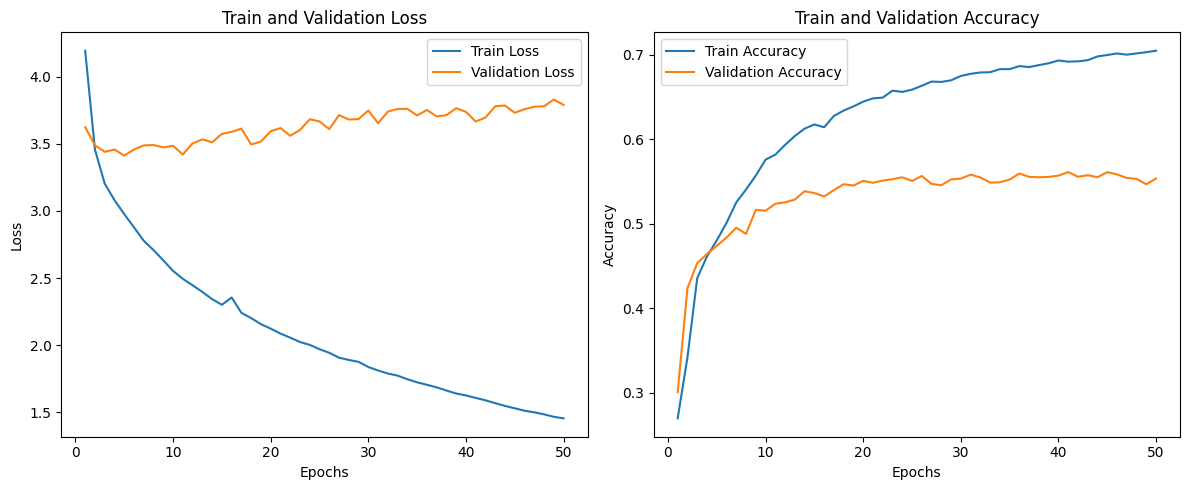

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#L2 regularization with adam optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initializing variables to save the model based on lowest training loss
best_train_loss = float('inf')
best_model_path = "best_model.pth"

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch_idx, (images, questions, answers) in enumerate(train_loader):
        images = images.to(device)
        questions_input_ids = questions['input_ids'].to(device)
        questions_attention_mask = questions['attention_mask'].to(device)
        answers = answers.to(device)

        optimizer.zero_grad()
        outputs = model(images, {'input_ids': questions_input_ids, 'attention_mask': questions_attention_mask})

        loss = criterion(outputs, answers)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, answers)

        print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Batch Loss: {loss.item():.4f}")

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, questions, answers in val_loader:
            images = images.to(device)
            questions_input_ids = questions['input_ids'].to(device)
            questions_attention_mask = questions['attention_mask'].to(device)
            answers = answers.to(device)

            outputs = model(images, {'input_ids': questions_input_ids, 'attention_mask': questions_attention_mask})
            loss = criterion(outputs, answers)

            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, answers)

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Saving the model based on lowest training loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with training loss: {best_train_loss:.4f}")

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# plot of training loss vs validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# plot of training accuracy vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Loading the best saved model
model.load_state_dict(torch.load(best_model_path))
model.to(device)

model.eval()

test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for images, questions, answers in test_loader:
        images = images.to(device)
        questions_input_ids = questions['input_ids'].to(device)
        questions_attention_mask = questions['attention_mask'].to(device)
        answers = answers.to(device)

        outputs = model(images, {'input_ids': questions_input_ids, 'attention_mask': questions_attention_mask})
        loss = criterion(outputs, answers)

        test_loss += loss.item()
        test_acc += calculate_accuracy(outputs, answers)

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 3.7643, Test Accuracy: 0.5577


## predicting on yes/no questions

In [ ]:
# filtering the yes/no questions based on the answers in the dataset
def filter_yes_no(dataset):
    return [item for item in dataset if item['answer'].lower() in ['yes', 'no']]

In [ ]:
train_yes_no = filter_yes_no(dataset['train'])
val_yes_no = filter_yes_no(dataset['validation'])
test_yes_no = filter_yes_no(dataset['test'])

yes_no_data = {
    'train': train_yes_no,
    'validation': val_yes_no,
    'test': test_yes_no
}

train_yes_no_dataset = VQADataset(train_yes_no, tokenizer, answer_to_id, transform=transform)
train_yes_no_loader = DataLoader(train_yes_no_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

val_yes_no_dataset = VQADataset(val_yes_no, tokenizer, answer_to_id, transform=transform)
val_yes_no_loader = DataLoader(val_yes_no_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

test_yes_no_dataset = VQADataset(test_yes_no, tokenizer, answer_to_id, transform=transform)
test_yes_no_loader = DataLoader(test_yes_no_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [ ]:
train_answers1 = [item['answer'] for item in train_yes_no]
val_answers1 = [item['answer'] for item in val_yes_no]
test_answers1 = [item['answer'] for item in test_yes_no]

# just to make sure if we have split the yes/no questions by checking the number of classes
all_answers1 = set(train_answers1 + val_answers1 + test_answers1)
unique_answers1 = list(all_answers1)
answer_to_id1 = {answer: idx for idx, answer in enumerate(unique_answers1)}
num_classes1 = len(unique_answers1)
print(num_classes1)

2


In [ ]:
test_yes_no[:5]

[{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=CMYK size=492x324>,
  'question': 'does mycobacterium avium infection in a duodenal biopsy from a patient with aids show massive intracellular macrophage infection with acid-fast organisms filamentous and pink in this acid-fast stain preparation?',
  'answer': 'yes'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1076x421>,
  'question': 'does microscopy show branching papillae having flbrovascular stalk covered by a single layer of cuboidal cells having ground-glass nuclei?',
  'answer': 'yes'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1076x421>,
  'question': 'does pbf show branching papillae having flbrovascular stalk covered by a single layer of cuboidal cells having ground-glass nuclei?',
  'answer': 'no'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1067x616>,
  'question': 'is chematic mechanisms involved in pathogenesis of two main types of diabetes mellit

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

model.eval()

test_yes_no_loss = 0.0
test_yes_no_acc = 0.0

with torch.no_grad():
    for images, questions, answers in test_yes_no_loader:
        images = images.to(device)
        questions_input_ids = questions['input_ids'].to(device)
        questions_attention_mask = questions['attention_mask'].to(device)
        answers = answers.to(device)

        outputs = model(images, {'input_ids': questions_input_ids, 'attention_mask': questions_attention_mask})
        loss = criterion(outputs, answers)

        test_yes_no_loss += loss.item()
        test_yes_no_acc += calculate_accuracy(outputs, answers)

test_yes_no_loss /= len(test_yes_no_loader)
test_yes_no_acc /= len(test_yes_no_loader)

print(f"Test Loss: {test_yes_no_loss:.4f}, Test Accuracy: {test_yes_no_acc:.4f}")

Test Loss: 0.6551, Test Accuracy: 0.8644


## Displaying the predicted answers with actual answers of yes/no questions

Question: does mycobacterium avium infection in a duodenal biopsy from a patient with aids show massive intracellular macrophage infection with acid - fast organisms filamentous and pink in this acid - fast stain preparation?
Actual Answer ID: no
Predicted Answer ID: no

Question: does microscopy show branching papillae having flbrovascular stalk covered by a single layer of cuboidal cells having ground - glass nuclei?
Actual Answer ID: no
Predicted Answer ID: no

Question: does pbf show branching papillae having flbrovascular stalk covered by a single layer of cuboidal cells having ground - glass nuclei?
Actual Answer ID: no
Predicted Answer ID: no

Question: is chematic mechanisms involved in pathogenesis of two main types of diabetes mellitus?
Actual Answer ID: no
Predicted Answer ID: no

Question: are numbers in the illustrations involved in pathogenesis of two main types of diabetes mellitus?
Actual Answer ID: no
Predicted Answer ID: no



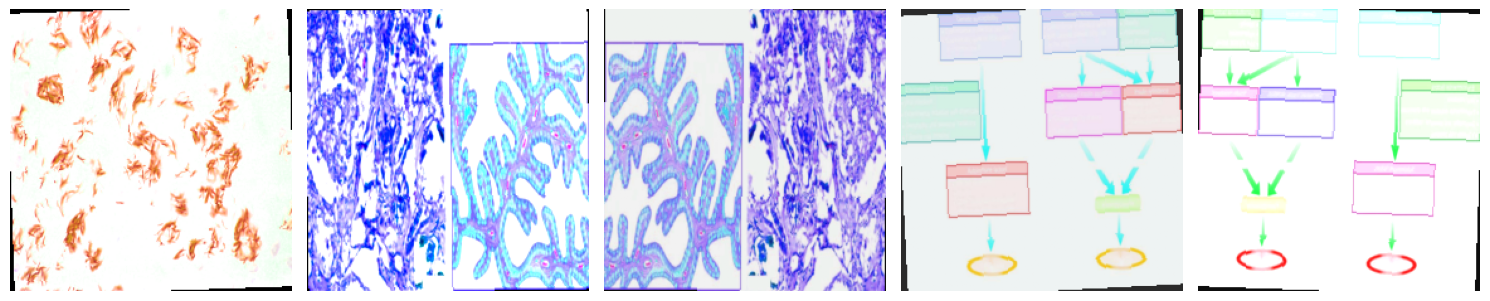

In [ ]:
import torch
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

model.eval()

def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        ax = axes[i]
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.axis('off')
    plt.tight_layout()
    plt.show()

data_iter = iter(test_yes_no_loader)
images, questions, answers = next(data_iter)

images = images.to(device)
questions_input_ids = questions['input_ids'].to(device)
questions_attention_mask = questions['attention_mask'].to(device)
answers = answers.to(device)

with torch.no_grad():
    outputs = model(images, {'input_ids': questions_input_ids, 'attention_mask': questions_attention_mask})
    _, predicted_labels = torch.max(outputs, 1)

questions_list = tokenizer.batch_decode(questions_input_ids, skip_special_tokens=True)

images = images.cpu()

# displaying the top 5 inputs and outputs
for i in range(5):
    print(f"Question: {questions_list[i]}")
    print(f"Actual Answer ID: {test_yes_no[answers[i].item()]['answer']}")
    print(f"Predicted Answer ID: {test_yes_no[predicted_labels[i].item()]['answer']}")
    print()

show_images(images[:5])

## predicting on count dataset

In [ ]:
# splitting the dataset based on the count questions by checking the answer is a number
def filter_count(dataset):
    return [item for item in dataset if item['answer'].isdigit()]

In [ ]:
train_count = filter_count(dataset['train'])
val_count = filter_count(dataset['validation'])
test_count = filter_count(dataset['test'])

count_data = {
    'train': train_count,
    'validation': val_count,
    'test': test_count
}

train_count_dataset = VQADataset(train_count, tokenizer, answer_to_id, transform=transform)
train_count_loader = DataLoader(train_count_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

val_count_dataset = VQADataset(val_count, tokenizer, answer_to_id, transform=transform)
val_count_loader = DataLoader(val_count_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

test_count_dataset = VQADataset(test_count, tokenizer, answer_to_id, transform=transform)
test_count_loader = DataLoader(test_count_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
test_count[:5]

[{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=792x528>,
  'question': 'how much week gestation gram infant lesion had ruptured causing 20 ml hemoperitoneum?',
  'answer': '30'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=792x528>,
  'question': 'what had adrenal of premature 30 week gestation gram infant lesion ruptured causing hemoperitoneum?',
  'answer': '20'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=792x528>,
  'question': 'how many cm does this image show cut surface lesion 76yobf?',
  'answer': '4'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=792x528>,
  'question': 'how many foot does this image show view of petrous portion temporal bone rather close-up 22yo man fall?',
  'answer': '37'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=792x521>,
  'question': 'how many antitrypsin does this image show liver, cirrhosis alpha-deficiency?',
  'answer': '1'}]

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

test_count_loss = 0.0
test_count_acc = 0.0

with torch.no_grad():
    for images, questions, answers in test_count_loader:
        images = images.to(device)
        questions_input_ids = questions['input_ids'].to(device)
        questions_attention_mask = questions['attention_mask'].to(device)
        answers = answers.to(device)

        outputs = model(images, {'input_ids': questions_input_ids, 'attention_mask': questions_attention_mask})
        loss = criterion(outputs, answers)

        test_count_loss += loss.item()
        test_count_acc += calculate_accuracy(outputs, answers)

test_count_loss /= len(test_count_loader)
test_count_acc /= len(test_count_loader)

print(f"Test Loss: {test_count_loss:.4f}, Test Accuracy: {test_count_acc:.4f}")

Test Loss: 7.4310, Test Accuracy: 0.3750
